In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import f1_score, classification_report
import gc # 垃圾回收
import matplotlib.pyplot as plt
import seaborn as sns

# 设置 Matplotlib/Seaborn 样式
sns.set(style='whitegrid')
# 设置 Pandas 显示选项
pd.set_option('display.max_columns', None)

In [2]:
print("正在加载特征化训练数据 (train_with_features.csv)...")
# 这可能需要几分钟，请耐心等待
try:
    df_train = pd.read_csv('train_with_features.csv', low_memory=False)
    print(f"数据加载成功！形状: {df_train.shape}")
except FileNotFoundError:
    print("错误：train_with_features.csv 文件未找到。")
    # 如果出错，停止执行
    raise

# -----------------------------------------------------------------
# 关键：恢复数据类型（CSV 丢失了它们）
# -----------------------------------------------------------------
print("正在恢复数据类型...")
# 1. 恢复时间列
df_train['t'] = pd.to_datetime(df_train['t'])

# 2. 恢复 ticker_id 为 'category'
# 这是 LightGBM 高效处理所必需的
df_train['ticker_id'] = df_train['ticker_id'].astype('category')

print("数据类型恢复完毕。")
print(df_train[['t', 'ticker_id', 'class_label']].head())

正在加载特征化训练数据 (train_with_features.csv)...
数据加载成功！形状: (1932, 68736)
正在恢复数据类型...
数据类型恢复完毕。
           t ticker_id class_label
0 2023-04-03         1         NaN
1 2023-04-05         1         NaN
2 2023-04-06         1         NaN
3 2023-04-11         1         NaN
4 2023-04-12         1         NaN


In [3]:
# 1. 定义 5 分类目标映射
# (HH=0, HL=1, LH=2, LL=3, NaN=4)
target_map = {
    'HH': 0,
    'HL': 1,
    'LH': 2,
    'LL': 3
}
# 我们将 'None' (即 NaN) 映射为 4

# 2. 映射
df_train['class_label_encoded'] = df_train['class_label'].map(target_map)
df_train['class_label_encoded'] = df_train['class_label_encoded'].fillna(4)
df_train['class_label_encoded'] = df_train['class_label_encoded'].astype(int)

print("目标变量编码完成。")
print(df_train['class_label_encoded'].value_counts().sort_index())

目标变量编码完成。
class_label_encoded
0      40
1      28
2      18
3      26
4    1820
Name: count, dtype: int64


In [4]:
# 1. 定义目标变量
TARGET = 'class_label_encoded'

# 2. 定义元数据列（这些不是特征）
# 确保排除所有非特征列
METADATA_COLS = ['class_label', 'class_label_encoded', 't', 'id', 'train_id']

# 3. 定义特征列
# 我们使用 df_train.columns.drop() 来安全地移除元数据列
# 即使 'id' 或 'train_id' 不存在也不会报错
features_to_drop = [col for col in METADATA_COLS if col in df_train.columns]
FEATURES = df_train.columns.drop(features_to_drop).tolist()

print(f"总特征数量 (原始 + 新增): {len(FEATURES)}")

# 4. 确认 'ticker_id' 仍在特征中
if 'ticker_id' in FEATURES:
    print("'ticker_id' 已正确包含在特征中。")
else:
    print("警告：'ticker_id' 未在特征中！")

# 5. 确认新特征被包含
fe_cols = [col for col in FEATURES if col.startswith('fe_')]
print(f"检测到 {len(fe_cols)} 个新创建的 'fe_' 特征。")

总特征数量 (原始 + 新增): 68732
'ticker_id' 已正确包含在特征中。
检测到 228 个新创建的 'fe_' 特征。


In [5]:
# -----------------------------------------------------------------# 修正 单元格 5：建立时间序列验证框架 (TSV) + 类型修复# -----------------------------------------------------------------# 1. 确保数据严格按 *原始* 基线的方式排序
print("正在按 't' 和 'ticker_id' 排序数据以进行验证分割...")
df_train = df_train.sort_values(by=['t', 'ticker_id']).reset_index(drop=True)

# 2. 定义分割点 (与基线完全一致)
split_percentage = 0.8
split_index = int(len(df_train) * split_percentage)

# 3. 分割数据
train_data = df_train.iloc[:split_index]
val_data = df_train.iloc[split_index:]

print(f"总训练样本数: {len(df_train)}")
print(f"新训练集样本数: {len(train_data)}")
print(f"新验证集样本数: {len(val_data)}")
print(f"验证集时间范围: {val_data['t'].min()} 到 {val_data['t'].max()}")

# 4. 创建 X (特征) 和 y (目标)
X_train = train_data[FEATURES]
y_train = train_data[TARGET]

X_val = val_data[FEATURES]
y_val = val_data[TARGET]

# -----------------------------------------------------------------# 💡 【错误修复】 强制转换数据类型# -----------------------------------------------------------------
print("正在修复 'object' 数据类型...")

# 找出 'ticker_id' 之外的所有特征列# (FEATURES 列表是在 CELL 4 中定义的)
numeric_features = [col for col in FEATURES if col != 'ticker_id']

# 遍历这些列，将它们强制转换为 float32# pd.to_numeric(..., errors='coerce') 会将所有无法转换的 'object' 值# 变成 NaN。LightGBM 默认可以高效处理 NaN。# 我们使用 .copy() 来避免 Pandas 的 SettingWithCopyWarning
X_train_copy = X_train.copy()
X_val_copy = X_val.copy()

for col in numeric_features:
    X_train_copy[col] = pd.to_numeric(X_train_copy[col], errors='coerce', downcast='float')
    X_val_copy[col] = pd.to_numeric(X_val_copy[col], errors='coerce', downcast='float')

# 替换回原来的变量
X_train = X_train_copy
X_val = X_val_copy

print(f"已将 {len(numeric_features)} 个特征列强制转换为数值类型。")
# -----------------------------------------------------------------# 5. 清理内存del df_train, train_data, val_data, X_train_copy, X_val_copy
gc.collect()

print("时间序列验证集创建完毕！")

正在按 't' 和 'ticker_id' 排序数据以进行验证分割...
总训练样本数: 1932
新训练集样本数: 1545
新验证集样本数: 387
验证集时间范围: 2024-09-20 00:00:00 到 2025-01-31 00:00:00
正在修复 'object' 数据类型...
已将 68731 个特征列强制转换为数值类型。
时间序列验证集创建完毕！


In [6]:
# 1. 定义 LightGBM 模型参数
lgb_params = {
    'objective': 'multiclass',
    'num_class': 5,             # 5 个类别 (HH, HL, LH, LL, None)
    'metric': 'multi_logloss',
    'n_estimators': 500,        # 增加树的数量 (之前是 200)
    'learning_rate': 0.05,
    'n_jobs': -1,
    'seed': 42,
    
    # 类别不平衡处理：仍然至关重要！
    'class_weight': 'balanced'
}

# 2. 初始化模型
model_v2 = lgb.LGBMClassifier(**lgb_params)

# 3. 训练模型
print("开始训练 Model v2 (使用新特征)...")
model_v2.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='multi_logloss',
    callbacks=[lgb.early_stopping(50)], # 增加耐心 (之前是 30)
    categorical_feature=['ticker_id'] # 必须指定
)

print("Model v2 训练完成！")

开始训练 Model v2 (使用新特征)...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078731 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27686
[LightGBM] [Info] Number of data points in the train set: 1545, number of used features: 7248
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[57]	valid_0's mul

In [7]:
# 1. 在验证集上进行预测
print("正在验证集上进行预测...")
val_preds = model_v2.predict(X_val)

# 2. 计算 Macro F1-Score
macro_f1_v2 = f1_score(y_val, val_preds, average='macro', zero_division=0)

print("\n========================================")
print(f"📈 Model v2 Macro F1-Score: {macro_f1_v2:.4f}")
print(f"📉 Baseline Macro F1-Score: 0.1905")
print("========================================")
print(f"🚀 性能提升: {macro_f1_v2 - 0.1905:.4f}")
print("========================================")

# 3. 打印详细的分类报告
target_map_full = {'HH': 0, 'HL': 1, 'LH': 2, 'LL': 3, 'None': 4}
target_names = [key for key, val in sorted(target_map_full.items(), key=lambda item: item[1])]
all_labels = [val for key, val in sorted(target_map_full.items(), key=lambda item: item[1])]

print("\n详细分类报告 (Model v2):")
print(classification_report(
    y_val, 
    val_preds, 
    target_names=target_names, 
    labels=all_labels,
    zero_division=0
))

正在验证集上进行预测...

📈 Model v2 Macro F1-Score: 0.2238
📉 Baseline Macro F1-Score: 0.1905
🚀 性能提升: 0.0333

详细分类报告 (Model v2):
              precision    recall  f1-score   support

          HH       0.50      0.10      0.17        10
          HL       0.00      0.00      0.00         9
          LH       0.00      0.00      0.00         4
          LL       0.00      0.00      0.00         5
        None       0.93      0.97      0.95       359

    accuracy                           0.91       387
   macro avg       0.29      0.21      0.22       387
weighted avg       0.88      0.91      0.89       387



正在绘制特征重要性...

--- 特征重要性分析 ---
在前 50 个最重要的特征中，有 46 个是我们新创建的 'fe_' 特征。


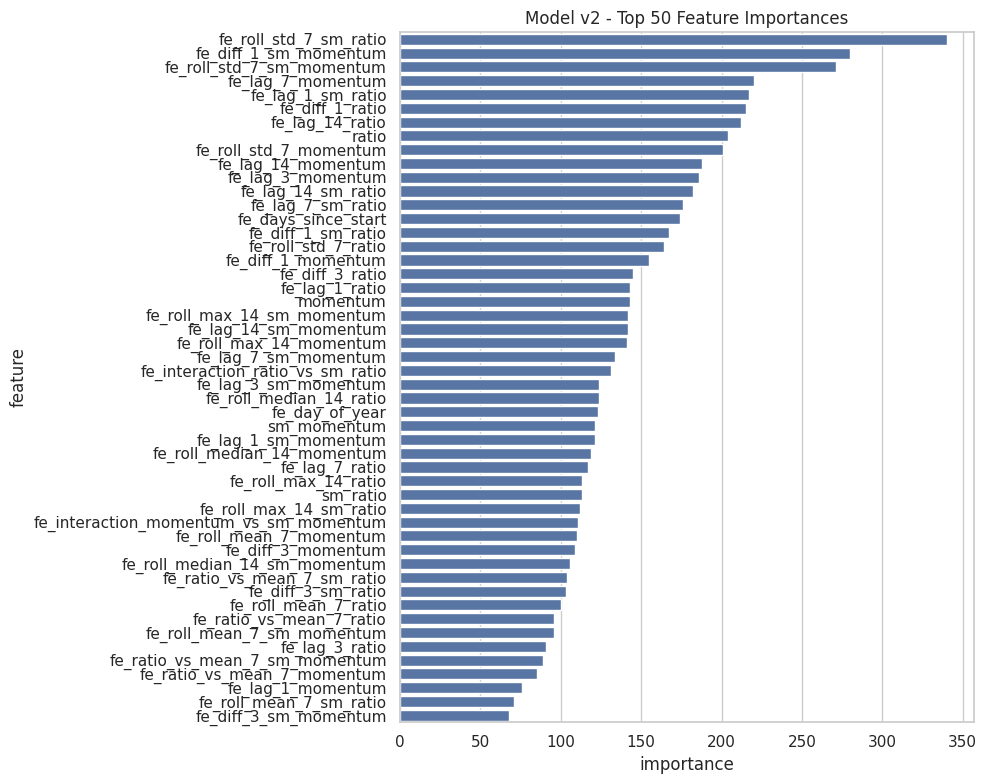

In [10]:
print("正在绘制特征重要性...")

# 提取特征重要性
importance_df = pd.DataFrame({
    'feature': model_v2.feature_name_,
    'importance': model_v2.feature_importances_
}).sort_values('importance', ascending=False)

# 检查 'fe_' 特征是否在 Top 50 中
top_50_features = importance_df.head(50)
new_feats_in_top_50 = top_50_features['feature'].str.startswith('fe_').sum()

print(f"\n--- 特征重要性分析 ---")
print(f"在前 50 个最重要的特征中，有 {new_feats_in_top_50} 个是我们新创建的 'fe_' 特征。")

# 绘制 Top 30 特征
plt.figure(figsize=(10, 8))
sns.barplot(
    x='importance', 
    y='feature', 
    data=importance_df.head(50)
)
plt.title('Model v2 - Top 50 Feature Importances')
plt.tight_layout()
plt.show()

In [11]:
# -----------------------------------------------
# 💡 新增：保存特征重要性，供 V3 模型使用
# -----------------------------------------------
importance_df.to_csv('feature_importance_v2.csv', index=False)
print("Feature importance (V2) 已保存到 'feature_importance_v2.csv'")

Feature importance (V2) 已保存到 'feature_importance_v2.csv'


In [2]:
!pip install seaborn -i https://pypi.tuna.tsinghua.edu.cn/simple

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 2.5 MB/s eta 0:00:00a 0:00:01
